## Chapter 12 - Bayesian Approaches to Testing a Point ("Null") Hypothesis

- [12.2.2 - Are different groups equal or not?](#12.2.2---Are-different-groups-equal-or-not?)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

import pytensor.tensor as pt
from matplotlib import gridspec

plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pytensor,matplotlib,numpy,pandas,pymc,seaborn

pytensor  : 2.8.10
matplotlib: 3.5.1
numpy     : 1.23.1
pandas    : 1.4.3
pymc      : 5.0.0
seaborn   : 0.12.2



#### Data
Using *R*, I executed lines 18-63 from the script `OneOddGroupModelComp2E.R` to generate the exact same data used in the book. The script can be downloaded from the book's website. After executing the lines, the List object `dataList` in *R* contains five elements:
 1. `nCond`: A scalar value (4) representing the number of conditions (background music types).
 2. `nSubj`: A scalar value (80) representing the number of subjects.
 3. `CondOfSubj`: A vector representing the condition (1, 2, 3 or 4) of a subject during a test.
 4. `nTrlOfSubj`: A vector with the number of trials/words per subject (20 for all subjects).
 5. `nCorrOfSubj`: A vector with number of correct recalls per subject.
 
I exported the last three elements of `dataList` to a csv file using the following command in *R*:   
`write.csv(data.frame(dataList[c(3:5)]), file='background_music.csv', row.names=FALSE)`

In [18]:
df = pd.read_csv("data/background_music.csv")

# map the condition descriptions to the condition codes
bgmusic = {1: "Das Kruschke", 2: "Mozart", 3: "Bach", 4: "Beethoven"}

cond_idx, cond_codes = pd.factorize(df["CondOfSubj"])

df["CondText"] = df["CondOfSubj"].map(bgmusic)

nCond = df["CondOfSubj"].nunique()
nSubj = len(df.index)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CondOfSubj   80 non-null     int64 
 1   nTrlOfSubj   80 non-null     int64 
 2   nCorrOfSubj  80 non-null     int64 
 3   CondText     80 non-null     object
dtypes: int64(3), object(1)
memory usage: 2.6+ KB


In [19]:
df.groupby('CondOfSubj').head(3)

,CondOfSubj,nTrlOfSubj,nCorrOfSubj,CondText
0,1,20,8,Das Kruschke
1,1,20,7,Das Kruschke
2,1,20,8,Das Kruschke
20,2,20,9,Mozart
21,2,20,12,Mozart
22,2,20,9,Mozart
40,3,20,11,Bach
41,3,20,6,Bach
42,3,20,11,Bach
60,4,20,6,Beethoven


### 12.2.2 - Are different groups equal or not?
Given the data, how credible is it that the 4 types of background music influence the ability to recall words 
**differently**?

In [20]:
# The means as mentioned in section 12.2.2
df.groupby('CondText', sort=False)['nCorrOfSubj'].mean()

CondText
Das Kruschke     8.0
Mozart          10.0
Bach            10.2
Beethoven       10.4
Name: nCorrOfSubj, dtype: float64

Note: in contrast to the *R* output in the book, the parameters in PyMC (like $\omega$ and model index) are indexed starting with 0.


Model 0 = condition specific $\omega_c$   
Model 1 = same $\omega$ for all conditions

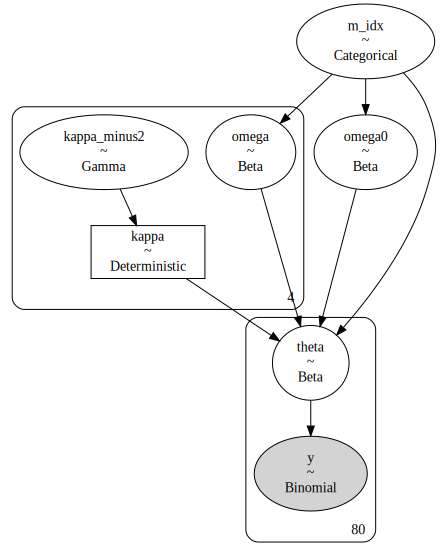

In [21]:
with pm.Model() as model_1:
    # constants
    aP, bP = 1.0, 1.0

    # Pseudo- and true priors for model 1.
    a0 = pt.as_tensor([0.48 * 500, aP])
    b0 = pt.as_tensor([(1 - 0.48) * 500, bP])

    # True and pseudopriors for model 0
    a = pt.as_tensor(
        np.c_[np.tile(aP, 4), [(0.40 * 125), (0.50 * 125), (0.51 * 125), (0.52 * 125)]]
    )
    b = pt.as_tensor(
        np.c_[
            np.tile(bP, 4),
            [(1 - 0.40) * 125, (1 - 0.50) * 125, (1 - 0.51) * 125, (1 - 0.52) * 125],
        ]
    )

    # Prior on model index [0,1]
    m_idx = pm.Categorical("m_idx", np.asarray([0.5, 0.5]))

    # Priors on concentration parameters
    kappa_minus2 = pm.Gamma("kappa_minus2", 2.618, 0.0809, shape=nCond)
    kappa = pm.Deterministic("kappa", kappa_minus2 + 2)

    # omega0
    omega0 = pm.Beta("omega0", a0[m_idx], b0[m_idx])

    # omega (condition specific)
    omega = pm.Beta("omega", a[:, m_idx], b[:, m_idx], shape=nCond)

    # Use condition specific omega when m_idx = 0, else omega0
    aBeta = pm.math.switch(
        pm.math.eq(m_idx, 0), omega * (kappa - 2) + 1, omega0 * (kappa - 2) + 1
    )
    bBeta = pm.math.switch(
        pm.math.eq(m_idx, 0),
        (1 - omega) * (kappa - 2) + 1,
        (1 - omega0) * (kappa - 2) + 1,
    )

    # Theta
    theta = pm.Beta("theta", aBeta[cond_idx], bBeta[cond_idx], shape=nSubj)

    # Likelihood
    y = pm.Binomial("y", n=df.nTrlOfSubj.values, p=theta, observed=df["nCorrOfSubj"])

pm.model_to_graphviz(model_1)

In [22]:
with model_1:
    idata1 = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m_idx]
>NUTS: [kappa_minus2, omega0, omega, theta]
CompoundStep
>BinaryGibbsMetropolis: [m_idx]
>NUTS: [kappa_minus2, omega0, omega, theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.


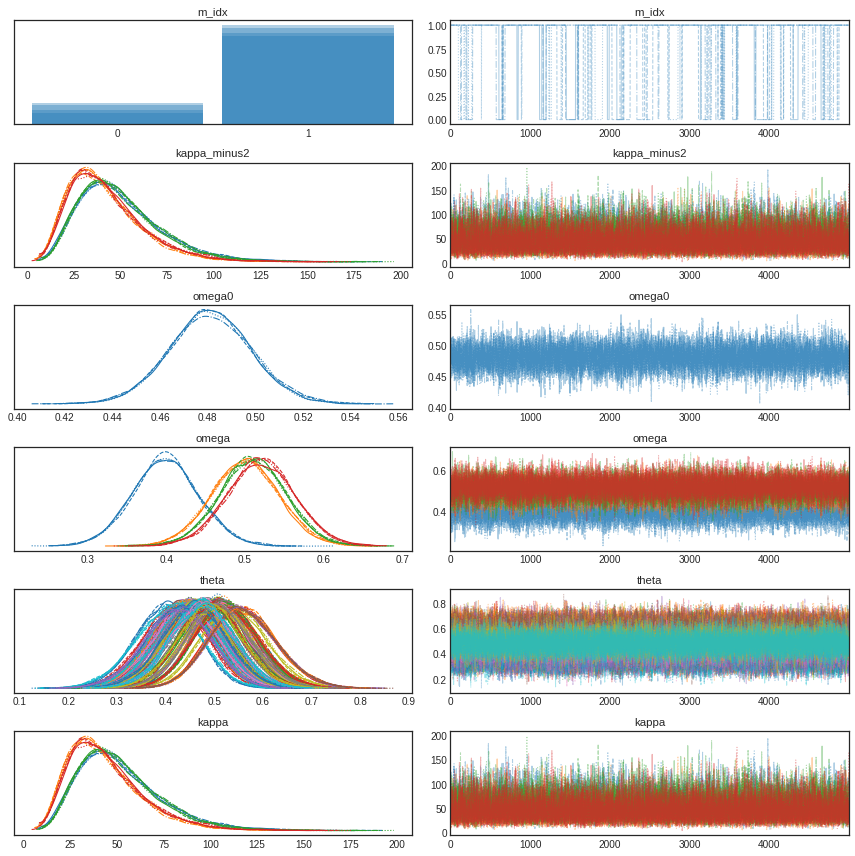

In [23]:
az.plot_trace(idata1)
plt.tight_layout();

#### Figure 12.5

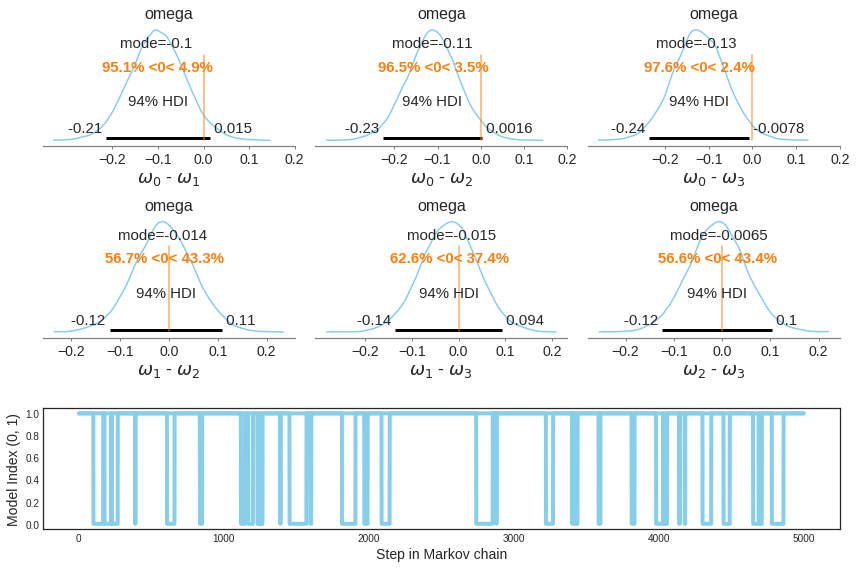

In [25]:
fig = plt.figure(figsize=(12, 8))

# define gridspec
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])
ax7 = plt.subplot(gs[2, :])

# group the first six axes in a list for easier access in loop below
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
# differences of posteriors to be displayed: omega x - omega y
x = [0, 0, 0, 1, 1, 2]
y = [1, 2, 3, 2, 3, 3]

# plot histograms
for ax, a, b in zip(axes, x, y):
    diff = idata1.posterior["omega"].sel(omega_dim_0=a) - idata1.posterior["omega"].sel(
        omega_dim_0=b
    )
    az.plot_posterior(diff, ref_val=0, point_estimate="mode", color=color, ax=ax)
    ax.set_xlabel("$\omega_{}$ - $\omega_{}$".format(a, b), fontdict={"size": 18})
    ax.xaxis.set_ticks([-0.2, -0.1, 0.0, 0.1, 0.2])

# plot trace values of model index (0, 1)
ax7.plot(
    np.arange(1, idata1.posterior["m_idx"].shape[1] + 1),
    idata1.posterior.sel(chain=0)["m_idx"],
    color=color,
    linewidth=4,
)
ax7.plot(
    np.arange(1, idata1.posterior["m_idx"].shape[1] + 1),
    idata1.posterior.sel(chain=1)["m_idx"],
    color=color,
    linewidth=4,
)
ax7.set_xlabel("Step in Markov chain", fontdict={"size": 14})
ax7.set_ylabel("Model Index (0, 1)", fontdict={"size": 14})
ax7.set_ylim(-0.05, 1.05)

fig.tight_layout()